In [1]:
from src.data.data_loader import read_articles, read_finished_paths, read_unfinished_paths, read_links, read_categories
from src.utils.HTMLParser import HTMLParser
from src.data.data_loader import read_all
import pandas as pd
import matplotlib.colors as mcolors
import plotly.express as px
import numpy as np



parser = HTMLParser()
parser.load_pickle()

In [2]:
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_sm, df_scat, df_article = read_all()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Usa', 'Rat', 'Test', 'Black ops 2', 'The Rock', 'Great', 'Podcast', 'Adolph Hitler', 'Bogota', 'Sportacus', 'Christmas', ' Zebra', 'Kashmir', 'Pikachu', 'Long peper', 'Macedonia', 'Mustard', 'Netbook', 'Rss', 'Georgia', 'Western Australia', 'English', 'Fats', 'The', 'Charlottes web'}
Invalid articles found in path: {'Pikachu', 'Wikipedia Text of the GNU Free Documentation License', 'Osteomalacia', 'Private Peaceful', 'Local community'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24709 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Local community', 'Osteomalacia', 'Pikachu'}
Number of rows after filtering: 51196


In [3]:
categories_others = ['Art',
 'Business Studies',
 'Citizenship',
 'Countries',
 'Design and Technology',
 'Everyday life',
 'Geography',
 'History',
 'IT',
 'Language and literature',
 'Mathematics',
 'Music',
 'People',
 'Religion',
 'Science',
 'Others',]

# colors for country and geo 
highlight_colors = {'Countries': '#2CB5AE','Geography': '#16A2F3'}

# shades of grey for other categories
num_greys = len(categories_others) - 2  # num of categories - country and geo 
grey_shades = [mcolors.to_hex((v, v, v)) for v in np.linspace(0.2, 0.4, num_greys)]
non_custom_categories = [cat for cat in categories_others if cat not in highlight_colors]
grey_palette = dict(zip(non_custom_categories, grey_shades)) ##here zip with a new 

# Combine custom colors and grey palette : final category palette
palette_category_dict = {**highlight_colors, **grey_palette}

In [4]:
#cut df into different colors
df_article_others = df_article[~df_article['category'].isin(['Countries', 'Geography'])]
df_article_countries = df_article[df_article['category']=='Countries']
df_article_geo = df_article[df_article['category']=='Geography']

# colors for country and geo articles
countries_articles_colors = dict.fromkeys(df_article_countries['article'], '#2CB5AE')
geo_articles_color = dict.fromkeys(df_article_geo['article'], '#16A2F3')
#colors for other articles
num_greys = len(df_article_others)
grey_shades = [mcolors.to_hex((v, v, v)) for v in np.linspace(0.2, 0.4, num_greys)]
articles_other = [art for art in df_article_others['article']]
grey_palette_articles = dict(zip(articles_other, grey_shades))

palette_articles_dict = {**countries_articles_colors, **geo_articles_color, **grey_palette_articles}

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

def get_nth_transition_matrix(df, article_names, transition):
    """
    Create the nth transition matrix based on the user paths.

    Parameters:
    - df (pd.DataFrame): The finished or unfinished paths.
    - article_names (pd.Series): The names of all the articles to consider for transitions
    - n (int): The position in the path to compute the transition (1 for first, 2 for second, etc.).

    Returns:
    - pd.DataFrame: A transition matrix for the nth position, with article_names as both rows and columns. Missing transitions are filled with 0.
    """
    
    df = df.copy()
    df['path_split'] = df['path'].str.split(';')
    df['current'] = df['path_split'].apply(lambda x: x[transition-1] if len(x) >= transition else None)
    df = df.dropna(subset=['current'])
    
    if df['current'].nunique() < 2:
        return pd.DataFrame(0, index=article_names, columns=article_names)
    
    df['next'] = df['path_split'].apply(lambda x: x[transition] if len(x) > transition else None)
    transition_counts = df.groupby(['current', 'next']).size().reset_index(name='count')

    transition_matrix = transition_counts.pivot(index='current', columns='next', values='count').fillna(0)
    transition_matrix = transition_matrix.reindex(index=article_names, columns=article_names, fill_value=0)
    
    return transition_matrix

def row_normalise(matrix):
    """Row-normalise the dataframe given in parameters"""

    row_sums = matrix.sum(axis=1)  
    normalized_matrix = matrix.div(row_sums, axis=0)  
    normalized_matrix[row_sums == 0] = 0  # Keep rows with sum = 0 as zero

    return normalized_matrix

def get_transition_probabilities(df_article_names, parser, backclicks=False):
    """
    Compute the transition probabilities for navigating between articles.

    Parameters:
    - df_article_names (pd.Series): A series of article names, representing the list of articles.
    - parser (object): An object with a `parsed_articles` attribute, where `parsed_articles` is a dictionary 
    that maps article names to their associated metadata, including a 'total_links' key containing the links from the article.
    - backclicks (bool, optional): If True, includes a "backclick" action as a possible navigation option,
    where backclick allows transitioning equally to any other article. Defaults to False.

    Returns:
    - np.ndarray: A square matrix of shape (actions, actions), where `actions` is the number of articles (or articles + 1 if backclicks are enabled). 
    Each entry [i, j] represents the probability of transitioning from article `i` to article `j`.
    """


    # are there any articles with no links? Not anymore. Are there disjoint sets that you cannot travel in both directions? I don't know
    actions = len(df_article_names) 

    if backclicks: 
        actions += 1

    transition_probabilities = np.zeros((actions, actions))
    
    if backclicks:
        transition_probabilities[:, 0] = 1  # in each article, backclick is a unique possible click choice
        transition_probabilities[0, :] = 1  # the article "backclick" is equally likely to lead to any article

    for i, art in enumerate(df_article_names):
        art_links = pd.Series(parser.parsed_articles[art]['total_links']).value_counts()
        indx = df_article_names[df_article_names.isin(art_links.index)]
        arts = np.array(indx.index.tolist())
        vals = art_links.loc[indx].values

        if backclicks: 
            i += 1
            arts += 1

        if arts.size > 0:
            transition_probabilities[i, arts] += vals

    transition_probabilities /= transition_probabilities.sum(axis=1)[:, np.newaxis]

    return transition_probabilities

In [6]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
np.count_nonzero(markov_transitions)

119855

## Eigenvalue analysis

<div class="alert alert-block alert-info">

The transition matrix's $P$ left eigenvector with eigenvalue 1 (i.e. $x$ such that $xP=x$) is called the steady-state of the system. Let's call the normalised vector $x = (x_1, x_2, \dots, x_N)$, where the sum of all $x_i$ is 1. After $\infty$ iterations, starting from whatever article, the probability distribution of the end article is given by $x$. 

**Example**: For 3 articles, let's say that we have $x=(0.2, 0.3, 0.5)$. Then, when starting from any of the articles and taking infinitely many steps, there is probability 0.2 to be in article 1, probability 0.3 to be in article 2 and probability 0.5 to be in article 3.

</div>

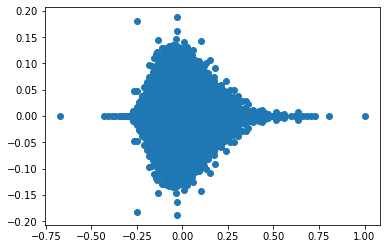

In [7]:
val, vec = np.linalg.eig(markov_transitions.T)
plt.scatter(val.real, val.imag)

In [8]:
ss = np.real(-vec[:, 0]) / np.real(-vec[:, 0]).sum()
top_indices = np.argsort(ss)[-20:][::-1]
df_article_names.iloc[top_indices]

4280       United States
1562              France
4276      United Kingdom
1427              Europe
1687             Germany
1383    English language
1433      European Union
4523        World War II
3554              Russia
1379             England
2176               Italy
2091               India
3815               Spain
1591     French language
2219               Japan
2409               Latin
893                China
906         Christianity
4279      United Nations
767               Canada
Name: article, dtype: object

<div class="alert alert-block alert-success">
There is indeed a vector with eigenvalue one, so there is a steady state in the system. To find the probabilities to be in a certain article in the steady state, we can look at the normalised values of the eigenvector. We see that United States is the most likely article to be in, followed mainly by a bunch of other countries.
</div>

## Comparing Network vs. Users first step

<div class="alert alert-block alert-info">

Let's start in any article $i$ and take $l$ steps in the network, which leads to article $j$. The probability of this happening by chance in the network is simply $P_{ij}(l)=A^l_{ij}$. To get probabilities of transitions for every pair of articles and path length $l$, we only need to take the $l$-th power of the transition matrix! This effectively characterises the bias of the network itself: if users pass by an article A very often BUT that only by chance you end up on the same article often too, we cannot conclude that the user made that choice. 

To characterise the user choices, we simply take the paths they created by playing. We can then similarly create a transition matrix based on observed data: just take the aggregated count of all the transitions from all starting articles. For instance, from article $i$ we count 2 transitions to article $j_1$, 3 to $j_2$ and none to $j_3$. The normalised transition probabilities for article $i$ are then $(0.4, 0.6, 0)$. 

The difference in transition probabilities $\Delta P=(0.4, 0.6, 0) - (0.2, 0.3, 0.5) = (0.2, 0.3, -0.5) \in [-1, 1]^3$ then gives an idea of how likely it is that a user purposedly made a choice and not only ended in an article by accident. A highly positive value means that even though the transition is very unlikely in the network, the user made that choice. A larger negative value means that a user took a path that is rather unlikely under the random walk assumption. The Markov Chain allows to filter out the network bias in the user decisions.

<b>Note:</b> Maybe look into odds instead of probabilities to be more rigorous? https://stats.stackexchange.com/questions/22796/compare-the-difference-of-two-probabilities-or-a-ratio-of-probabilities

</div>

In [9]:
user_transitions = row_normalise(get_nth_transition_matrix(df_finished, df_article_names, 1))
np.count_nonzero(user_transitions.to_numpy())

25151

In [10]:
diff = user_transitions-markov_transitions

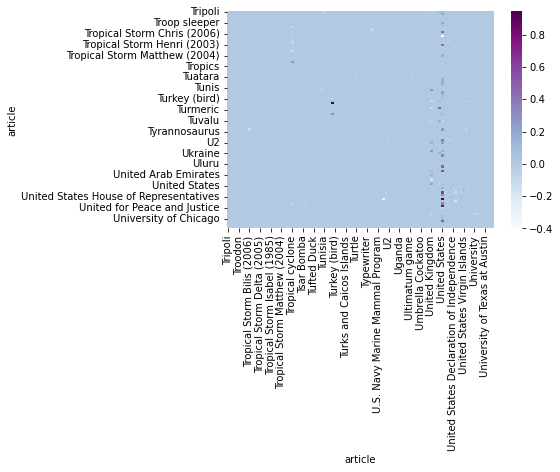

In [11]:
sn.heatmap(diff.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.show()

In [12]:
mean_diff_indegree = diff.sum(axis=0).sort_values(ascending=False)
mean_diff_indegree

article
United States                219.681123
Europe                       100.233262
England                       95.131996
United Kingdom                69.586810
World War II                  40.748234
                                ...    
Animal                       -10.015920
Carolus Linnaeus             -10.290777
Binomial nomenclature        -18.524412
Chordate                     -19.782002
Scientific classification    -21.930998
Length: 4584, dtype: float64

<div class="alert alert-block alert-success">

For the first transition, much more users go to United States or Europe than only following random transitions would.

<b>Notes:</b> 
- Values close to 0 means it is close to random behaviour. Values that are closer to -1 or 1 are the special behaviour, either clicking much more or much less on certain articles than random would predict.
- How could we remove the link position bias? Maybe check if certain links are on the top/bottom of the page and give more or less importance accordingly?
- Does adding backclicks as in the function above make sense?
</div>

## Longer path lengths ($l>1$) comparison

In [13]:
l = 1
user_transitions_l = row_normalise(get_nth_transition_matrix(df_finished, df_article_names, l))
markov_transitions_l = np.linalg.matrix_power(get_transition_probabilities(df_article_names, parser, backclicks=False), l)
diff_l = user_transitions_l - markov_transitions_l
mean_diff_l = diff_l.sum(axis=0).sort_values(ascending=False)


<div class="alert alert-block alert-danger"> 

- Check step by step: same transition matrix for every step to see the user choices vary along the path
- And by path: transition probability over longer paths $l>1$ (updated transition matrix for probability of user to be in j starting from i)
  
</div>

## How does user's deviation from random path evolve during games ?


<div class="alert alert-block alert-success">
We can look at the difference between user games and random games at different steps of the game. This highlights the evolution of which articles palyers **voluntarily chose** to visit at different stages of the game. 
</div>

In [14]:
#two choices to justify:
# 1) the number of steps to look at : we chose 5 as results  already stabilize 
# 2) what are articles we look at; we chose the 6 that have the most positive difference (differences are less extreme in the negatives, so less interesting as they show less evidence of voluntary choice) 

mean_diff_step = [] #list of the difference between game and random : represents user choice 
articles_to_investigate = [] #select 6 articles per step (at most, no duplicates) that differ the most from random chance : aka the articles for which we have the most evidence for voluntary player choice

for n in range(1,6):
    # get transition matrices of the 5 first steps of users and markov
    user_transitions_n = row_normalise(get_nth_transition_matrix(df_finished, df_article_names,n))
    markov_transitions_n = np.linalg.matrix_power(get_transition_probabilities(df_article_names, parser, backclicks=False), n)
    
    #compute column wise sum of the difference between user and random : gives the sum of probalities of player voluntarily chosing to transition to article j
    diff_n = user_transitions_n - markov_transitions_n
    mean_diff_n = diff_n.sum(axis=0).sort_values(ascending=False)
    
    #store the difference  
    mean_diff_step.append(mean_diff_n)
    
    #store 6 articles that have the most evidence of being chosen by the player 
    articles_n = list(mean_diff_n.keys()[:6])
    for article in articles_n:
        if article not in articles_to_investigate:
            articles_to_investigate.append(article) 

In [15]:
# df of differences of all articles at 5 different steps
mean_diff_steps = pd.DataFrame(mean_diff_step)

# Only keep columns taht are articles to investigate
mean_diff_steps_main = mean_diff_steps.drop([col for col in mean_diff_steps.columns if col not in articles_to_investigate], axis=1)
mean_diff_steps_main_T = mean_diff_steps_main.transpose().reset_index()

diff_steps_main = mean_diff_steps_main_T.melt(id_vars='article',
                                              value_vars=[0,1,2,3,4],
                                              var_name='Step',
                                              value_name='Cumulative difference')

fig = px.line(data_frame=diff_steps_main,
              x='Step',
              y='Cumulative difference',
              color='article',
              title='Stepwise deviation from random path, per article and for articles with higest deviation',
              color_discrete_map=palette_articles_dict
              )
fig.add_hline(
    y=0,  
    line=dict(color='black', dash='dash' ),  
    annotation_text="Random path",  
    annotation_position="bottom right",  
    annotation_font=dict(size=12, color="black")  
)

fig.show()

### What about the evolution of categories ?

In [16]:
#get level 1 categories for each articles
mean_diff_steps = pd.DataFrame(mean_diff_step)
mean_diff_steps_T = mean_diff_steps.transpose().reset_index()
mean_diff_steps_cat = mean_diff_steps_T.merge(right=df_article[['category', 'article']], on='article', how='left')

#sum probabilities of articles of the same category 
mean_diff_step_cat = mean_diff_steps_cat.groupby('category').agg('sum').reset_index().drop(columns='article')

In [34]:
# melt df to get one col for the step, and one col for the category-difference
df_long = mean_diff_step_cat.melt(id_vars='category', 
                                  value_vars=[0, 1, 2, 3, 4], 
                                  var_name='Step', 
                                  value_name='Cumulative difference')

#plot evolution
fig = px.line(df_long, 
              x='Step', 
              y='Cumulative difference', 
              color='category', 
              title='Stepwise deviation from random path, per category',
              color_discrete_map=palette_category_dict,
              )
fig.add_hline(
    y=0,  
    line=dict(color='black', dash='dash' ),  
    annotation_text="Random path",  
    annotation_position="top right",  
    annotation_font=dict(size=12, color="black")  
)
fig.show()

In [18]:
#TODO add a measure of variance as shaded region around your main line

<div class="alert alert-block alert-success">
The Countries and Geography categories have similar behaviors, having extreme values, both strongly positive values for the first transition (~200 and 70 respectively), and strongly negative values in later steps (between -500 and -1000 and between -350 and -550 respectively).

- The stronly positive values for the first transition shows strong evidence that the first click of players are voluntarily directed towards Countries and Geography articles.

- The strong negative values for following steps shows strong evidence that folowing the first clicks, players voluntarily direct their click towards other categories.  

Further study of the evolution of country and geography articles is needed to explore where those strong values come from.

Let's look at articles of the Countries category more specifically:
</div>

In [33]:
#plot only countries articles
mean_diff_steps_country = mean_diff_steps_cat.loc[mean_diff_steps_cat['category']=='Countries']

mean_diff_steps_country_melt = mean_diff_steps_country.melt(id_vars='article',
                                                       value_vars=[0,1,2,3,4],
                                                       var_name='Step',
                                                       value_name='Cumulative difference')

fig = px.line(data_frame=mean_diff_steps_country_melt,
              x='Step',
              y='Cumulative difference',
              color='article',
              title='Stepwise deviation from random path, per countries articles',
              )
fig.add_hline(
    y=0,  
    line=dict(color='black', dash='dash' ),  
    annotation_text="Random path",  
    annotation_position="top right",  
    annotation_font=dict(size=12, color="black")  
)
fig.show()

<div class="alert alert-block alert-success">
Interestingly, no strongly negative values appear in later steps. This indicates that the strong negative values in the category plot is likely due to the accumulation of many small negative deviation from the random path. 

Lets verify this assimption by grouping articles that stay close to the random path as 'Others' article, and plotting their mean, and the value of their sum. 
</div>

In [40]:
#choice to justify : threshold
threshold_other=15

# get all rows where diff values are close to 0 (absolute value is under threshold)
minor_articles_country = mean_diff_steps_country[mean_diff_steps_country[[0,1,2,3,4]].abs().lt(threshold_other).all(axis=1)]
print(f"Out of {len(mean_diff_steps_country)} country articles, {len(minor_articles_country)} dont show strong evidence of user choice, and will be groupped as 'Others'")
print(f"Let's study the {len(mean_diff_steps_country)-len(minor_articles_country)} remaining articles along 'Others'.")

Out of 229 country articles, 220 dont show strong evidence of user choice, and will be groupped as 'Others'
Let's study the 9 remaining articles along 'Others'.


In [31]:
#Plot countries articles, regrouping the ones that dont vary much into 'Others'
#get their average at each step
avg = minor_articles_country[[0,1,2,3,4]].agg('mean',axis=0)
avg_row = {'article': 'Others_mean', **avg.to_dict(), 'category':'Countries'}
#get their sum at each step 
total_other = minor_articles_country[[0,1,2,3,4]].agg('sum', axis=0)
total_row ={'article':'Others_sum', **total_other.to_dict(), 'category':'Countries'}

#remove lines of minor articles
mean_diff_steps_country_droped = mean_diff_steps_country[~mean_diff_steps_country['article'].isin(minor_articles_country['article'])].copy()

# add 'Others' line : average and sum of removed lines
mean_diff_steps_country_droped.loc[len(mean_diff_steps_country_droped)] = avg_row
mean_diff_steps_country_droped.loc[len(mean_diff_steps_country_droped)] = total_row

mean_diff_steps_country_droped_melt = mean_diff_steps_country_droped.melt(id_vars='article',
                                    value_vars=[0,1,2,3,4],
                                    var_name='Step',
                                    value_name='Cumulative difference',
                                    )
fig = px.line(data_frame=mean_diff_steps_country_droped_melt,
        x='Step',
        y='Cumulative difference',
        color='article',
        title='Stepwise deviation from random path, per major Countries article')
fig.add_hline(
    y=0,  
    line=dict(color='black', dash='dash' ),  
    annotation_text="Random path",  
    annotation_position="top right",  
    annotation_font=dict(size=12, color="black")  
)
fig.show()

<div class="alert alert-block alert-success">
A great majority of countries articles are clicked close to randomly (the difference between player path and random path is close to 0), but they are so numerous that they cumulate to be very significant in the country category.

These articles being so influent in the category stats and being close to random, we could make the choice to ingore them by :
finding a way for them not to influence so much the category: by removing them? by expressing them under 'Other_mean'? how to justify this choice? 
</div>

## Small Example

In [25]:
example_articles = pd.Series(['United States', 'France', 'Agriculture', 'Mexico', 'Natural gas'])

tp = get_transition_probabilities(example_articles, parser, backclicks=True)

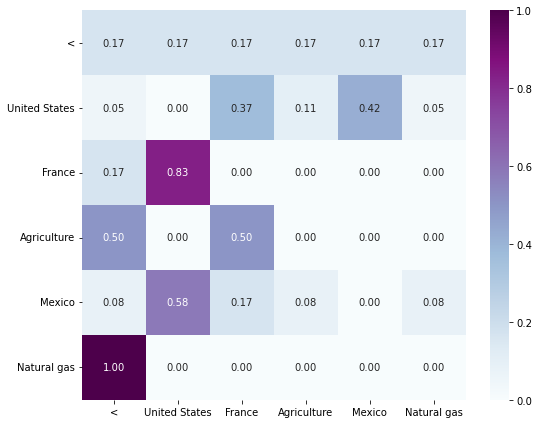

In [26]:
plt.figure(figsize=(8, 6))
sn.heatmap(np.linalg.matrix_power(tp, 1), cmap='BuPu', annot=True, fmt=".2f", cbar=True)

plt.xticks(np.arange(6) + 0.5, ['<'] + example_articles.to_list(), rotation=0)  # Keep x-ticks horizontal
plt.yticks(np.arange(6) + 0.5, ['<'] + example_articles.to_list(), rotation=0)  # Make y-ticks horizontal

plt.tight_layout()
plt.show()

In [27]:
eigval, eigvec = np.linalg.eig(tp.T)
steady_state = eigvec[:, 0] / np.sum(eigvec[:, 0])
print(np.isclose(steady_state @ tp, steady_state)) # testing if the vector is really a left eigenvector with eigenvalue 1

[ True  True  True  True  True  True]


In [28]:
steady_state # 0.19% end up in "<", 0.29% in "United States", ...

array([0.19663573, 0.29825261, 0.20772912, 0.07736369, 0.15835267,
       0.06166618])

In [29]:
example_articles = pd.Series(['United States', 'France', 'Agriculture', 'Mexico'])
markov_example = get_transition_probabilities(example_articles, parser, backclicks=False)
user_example = row_normalise(user_transitions[example_articles].loc[example_articles])
diff_example = user_example-markov_example

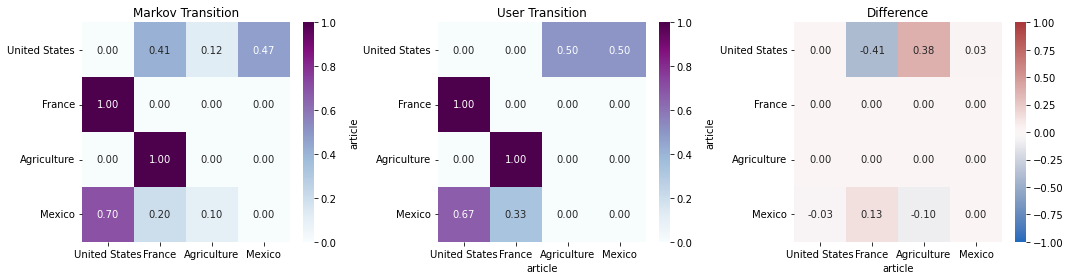

In [30]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
sn.heatmap(markov_example, cmap='BuPu', annot=True, fmt=".2f", cbar=True, vmin=0, vmax=1)
plt.xticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Keep x-ticks horizontal
plt.yticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Make y-ticks horizontal
plt.title('Markov Transition')

plt.subplot(132)
sn.heatmap(user_example, cmap='BuPu', annot=True, fmt=".2f", cbar=True, vmin=0, vmax=1)
plt.xticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Keep x-ticks horizontal
plt.yticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Make y-ticks horizontal
plt.title('User Transition')

plt.subplot(133)
sn.heatmap(diff_example, cmap='vlag', annot=True, fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.xticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Keep x-ticks horizontal
plt.yticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Make y-ticks horizontal
plt.title('Difference')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

For France and Agriculture, the Markov Chain perfectly aligns with the observations. For Mexico, it is a very close match, slightly more people than random go to France and slightly less to Agriculture and United States. For United States, many more people went to Agriculture than predicted and less to France.
</div>